# 0. Введение

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

#  1. Сведение к ADMM

Сведём нашу задачу пригодную для решения алгоритмом ADMM(Правила восстановления, через модифицированную функцию Лагранжа):
$$ \min_{X}\|X \|_* $$
$$  X_{i,j} = Y_{i,j}, (i,j) \in E, X_* = \sum \sigma_i(X) $$
Заведём индикаторную функцию на множестве матриц, таком, что $X_{i,j} = Y_{i,j}, (i,j) \in E$, т.е множестве: $S=\{X | X_{i,j} = Y_{i,j}, (i,j) \in E\}$. Тогда наша задача будет выглядить следующим образом:
$$\min_{X=Z} \|X \|_* + I_S(Z)$$
Данную задачу мы можем решить алгоритмом ADMM

#  2. Метод модифицированной функции Лагранжа

Надо решить задачу со следующими ограничениями:
$$\begin{cases}
f(x) \rightarrow min \\
f_{i}(x) \leqslant 0, 1 \leqslant i \leqslant k \\
g_{i}(x) = 0, 1 \leqslant i \leqslant m
\end{cases}$$
Введём функцию Лагранжа: 
$$L(x, \lambda, \mu) = f(x) + \sum\limits_{i = 1}^{k} \lambda_{i} f_{i}(x) + \sum\limits_{i = 1}^{m} \mu_{i} g_{i}(x)$$
Модифицированный Лагранж(добавляем внешние штрафы):
$$ \widetilde{L}(x, \lambda, \mu) = f(x) + \sum\limits_{i = 1}^{k} \lambda_{i} f_{i}(x) + \sum\limits_{i = 1}^{m} \mu_{i} g_{i}(x) + r(\sum\limits_{i = 1}^{m} g_{i}^2 (x) + \sum\limits_{i = 1}^{k} [f_i(x)]^2_{+})$$
Где $[f_i(x)]_{+} = max\{f_{i}(x), 0\}$ - срезка. Преобразуем так, чтобы выделить полный квадрат:
$$\widetilde{L}(x, \lambda, \mu) = f(x) + \frac{1}{4r} \sum\limits_{i = 1}^{m}(\mu_{i} + 2rg_{i}(x))^2 + \frac{1}{4r} \sum\limits_{i = 1}^{k}[\lambda_{i} + 2rf_{i}(x)]_{+}^2 - \sum\limits_{i = 1}^{k} \frac{\lambda_{i}}{4r} - \sum\limits_{i = 1}^{m} \frac{\mu_{i}}{4r}$$
Рассмотрим его экстремальные точки: 
$$0  = \frac{\partial}{\partial \mu_{i}} \widetilde{L}(x, \lambda, \mu) = \frac{1}{2r}(\mu_{i} + 2rg_{i}(x)) - \frac{\mu_{i}}{2r} \Rightarrow \mu_i = \mu_i + 2rg_{i}(x) \Rightarrow g_{i}(x) = 0$$
$$0  = \frac{\partial}{\partial \lambda_{i}} \widetilde{L}(x, \lambda, \mu) = \frac{1}{2r}[\lambda_{i} + 2rf_{i}(x)]_{+} - \frac{\lambda_{i}}{2r} \Rightarrow \lambda_i = [\lambda_i + 2rf_{i}(x)]_{+} \Rightarrow \lambda_{i} f_{i}(x) = 0$$
$$0  = \frac{\partial}{\partial x} \widetilde{L}(x, \lambda, \mu) = \nabla f(x) + \sum\limits_{i = 1}^{m}(\mu_{i} + 2rg_{i}(x))\nabla g_{i}(x) + \sum\limits_{i = 1}^{k}[\lambda_{i} + 2rf_{i}(x)]_{+} \nabla f_{i}(x)$$
$$ \frac{\partial}{\partial x} \widetilde{L}(x, \lambda, \mu) = \nabla f(x) + \sum\limits_{i = 1}^{m} \mu_{i} \nabla g_{i}(x) + \sum\limits_{i = 1}^{k} \lambda_{i} \nabla f_{i}(x) = \frac{\partial}{\partial x} L(x, \lambda, \mu) = 0$$
То есть у $\widetilde{L} (x, \lambda, \mu)$ и $L(x, \lambda, \mu)$ одинаковые точки экстремума, тогда наши правила обновления:
$$\begin{cases}
\mu_i^{k+1} = \mu_i^{k} + 2rg_{i}(x^{k}) \\
\lambda_i^{k+1} = [\lambda_i^{k} + 2rf_{i}(x^{k})]_{+} \\
x^{k+1} = \inf\limits_{x} \widetilde{L} (x, \lambda^{k+1}, \mu^{k+1})
\end{cases}$$

# 3. ADMM

Рассмотрим задачу минимизации по двум переменным:
$$\begin{cases}
f(x) + g(z) \rightarrow \min\limits_{x, z} \\
Ax + Bz = c
\end{cases}$$
Тогда метод модифицированной функции Лагранжа: 
$$\widetilde{L} (x, z, \lambda) = f(x) + g(x) + \lambda^T(Ax + Bz - c) + \frac{r}{2} \|Ax + Bz - c\|_2^2$$
Что сделает ММФЛ:
$$\begin{cases}
\lambda^{k+1} = \lambda^{k} + 2r(Ax^{k} + Bz^{k} - c) \\
\begin{pmatrix}
  x^{k+1} \\
  z^{k+1}
\end{pmatrix} = argmin_{x, z} \widetilde{L} (x, z, \lambda^{k+1})
\end{cases}$$
Что делает ADMM - Вместо поиска $argmin_{x, z}$ по двум переменным, поочерёдно фиксирует одну из переменных и вычисляет $argmin$ по другой. Итоговые правила обновления ADMM:
$$\begin{cases}
\lambda^{k+1} = \lambda^{k} + 2r(Ax^{k} + Bz^{k} - c) \\
x^{k+1} = argmin_{x} \widetilde{L} (x, z^{k}, \lambda^{k+1}) \\
z^{k+1} = argmin_{z} \widetilde{L} (x^{k}, z, \lambda^{k+1})
\end{cases}$$

# 4. Задача восстановления картинки(теория)

Метод модиффицированной функции Лагранжа:
$$
L = \|X \|_* + \lambda^{T} (X-Z) + \frac{r}{2}\|X-Z\|^2
$$
Правила обновления из семинара для такой задачи:
$$ \lambda_{k+1} = \lambda_k + r(X_k-Z_k)$$
$$ X_{k+1} = prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right)$$
$$ Z_{k+1} = \pi_{S}\left(X_k + \frac{\lambda_{k+1}}{r}\right)$$
$$prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right) = argmin_{K}\left(\frac{r}{2}\left|\left|K - \left(Z_k - \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 + \|K \|_*\right)$$

$$\pi_{S}\left(X_k + \frac{\lambda_{k+1}}{r}\right) = argmin_{K\in S}\left(\frac{r}{2}\left|\left|K - \left(X_k + \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 \right)$$

$Argmin$ для $X_{k+1}$:

$$
0 = \frac{\partial \|K \|_*}{\partial K} + r\left(K - \left(Z_k - \frac{\lambda_{k+1}}{r}\right)\right)
$$
Воспользуемся SVD разложением:  $K = U\Sigma V^T$
$$
\frac{\partial \|K \|_*}{\partial K} = \frac{\partial \|U\Sigma V^T \|_*}{\partial K} = \frac{\partial tr(\Sigma)}{\partial K} = \frac{\partial tr\left(U^T\Sigma V\right)}{\partial K} = \frac{<I,U^T\partial KV>}{\partial K} = UV^T
$$

$$
X_{k+1} = prox_{\|X \|_*, r}\left(Z_k - \frac{\lambda_{k+1}}{r}\right) = K_{min} = Z_k - \frac{\lambda_{k+1}}{r} - \frac{UV^T}{r}
$$

$Argmin$ для $Z_{k+1}$:

$$
Z_{k+1} = argmin_{K\in S}\left(\frac{r}{2}\left|\left|K - \left(X_{k+1} + \frac{\lambda_{k+1}}{r}\right)\right|\right|^2_2 \right) = K_{min} \in S = X_{k+1} + \frac{\lambda_{k+1}}{r} \in S,
$$

Если $(i,j) \in E$, то $Z_{k+1} = Y$, а если $(i,j) \notin E$, $Z_{k+1} = K_{min}$

Итог:
$$ \lambda_{k+1} = \lambda_k + r(X_k-Z_k)$$

$$ X_{k+1} = Z_k - \frac{\lambda_{k+1}}{r} - \frac{UV^T}{r}$$

$$ Z_{k+1} = \begin{cases}
& X_{k+1} + \frac{\lambda_{k+1}}{r}, (i,j) \notin E\\
& Y, (i,j) \in E\\
\end{cases} $$

# 5. Задача восстановления картинки(код)

Переводим нашу картинку в 3D матрицу: 

In [2]:
import matplotlib.image as img 
image = img.imread("Picture.jpg") 
Y = image /256
print (image.shape)

(480, 852, 3)


Генерируем матрицу-маску, которая будет задавать искажения нашей картинки

In [3]:
E = np.random.randint(0, 2, (image.shape[0], image.shape[1]))

Хотим работать с 2D матрицей, поэтому разделим матрицу по потокам: красный, синий и красный

In [4]:
X_red = np.zeros((image.shape[0],image.shape[1]))
Y_red = Y[:,:,0]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_red[i][j] = Y_red[i][j] * E[i][j]
print(X_red)

[[0.         0.         0.         ... 0.16015625 0.         0.16015625]
 [0.41015625 0.41015625 0.41015625 ... 0.         0.         0.        ]
 [0.41015625 0.41015625 0.41015625 ... 0.16015625 0.         0.16015625]
 ...
 [0.         0.         0.01171875 ... 0.         0.69921875 0.        ]
 [0.01171875 0.         0.         ... 0.         0.69921875 0.        ]
 [0.         0.01171875 0.01171875 ... 0.6953125  0.         0.        ]]


In [5]:
X_blue = np.zeros((image.shape[0],image.shape[1]))
Y_blue = Y[:,:,1]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_blue[i][j] = Y_blue[i][j] * E[i][j]
print(X_blue)

[[0.         0.         0.         ... 0.9375     0.         0.9375    ]
 [0.046875   0.046875   0.046875   ... 0.         0.         0.        ]
 [0.046875   0.046875   0.046875   ... 0.9375     0.         0.9375    ]
 ...
 [0.         0.         0.265625   ... 0.         0.421875   0.        ]
 [0.265625   0.         0.         ... 0.         0.421875   0.        ]
 [0.         0.265625   0.265625   ... 0.41796875 0.         0.        ]]


In [6]:
X_green = np.zeros((image.shape[0],image.shape[1]))
Y_green = Y[:,:,2]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        X_green[i][j] = Y_green[i][j] * E[i][j]
print(X_green)

[[0.         0.         0.         ... 0.23828125 0.         0.23828125]
 [0.60546875 0.60546875 0.60546875 ... 0.         0.         0.        ]
 [0.60546875 0.60546875 0.60546875 ... 0.23828125 0.         0.23828125]
 ...
 [0.         0.         0.9921875  ... 0.         0.         0.        ]
 [0.9921875  0.         0.         ... 0.         0.0078125  0.        ]
 [0.         0.9921875  0.9921875  ... 0.00390625 0.         0.        ]]


Получим искажённую картинку:

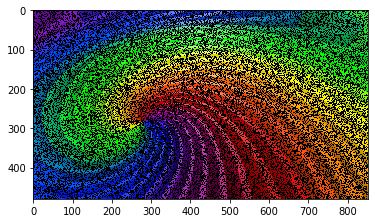

In [7]:
X_finish = np.zeros((image.shape[0], image.shape[1], 3))
X_finish[:,:,0] = X_red
X_finish[:,:,1] = X_blue
X_finish[:,:,2] = X_green
plt.imshow(X_finish)

Напишем функцию ADMM

In [14]:
Z = np.zeros((image.shape[0],image.shape[1]))
r = 1
def Update_ADMM(X, Z, l, Y_initial):
    l_new = l + r*(X - Z)
    U, S, V = np.linalg.svd(X, full_matrices=False) #V - выдаётся уже транспонированная
    X = Z - l_new / r - (U @ V) / r
    Z = X + l_new / r 
    Z[E==1] = Y_initial[E==1]
    print(np.sum(S))
    return X, Z, l_new

Пропустим ADMM алгоритм по кажому потоку и отследим значение нашей нормы(в данном случае она равна сумме элементов матрицы $\Sigma$:

In [15]:
steps = 50
lamda_1 = np.zeros((image.shape[0],image.shape[1]))
Z_1 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_red, Z_1, lamda_1 = Update_ADMM(X_red, Z_1, lamda_1, Y_red)

  4%|███▎                                                                               | 2/50 [00:00<00:06,  7.36it/s]

1668.4330029688304
2148.43300296883


  8%|██████▋                                                                            | 4/50 [00:00<00:05,  7.71it/s]

7790.5314093326
3302.905611175109


 12%|█████████▉                                                                         | 6/50 [00:00<00:05,  7.63it/s]

3482.6418939689393
3260.6024750276747


 16%|█████████████▎                                                                     | 8/50 [00:01<00:06,  6.93it/s]

3161.226678750093
2988.5532920109044


 20%|████████████████▍                                                                 | 10/50 [00:01<00:05,  7.33it/s]

2903.299964524316
2760.346045594708


 24%|███████████████████▋                                                              | 12/50 [00:01<00:04,  7.88it/s]

2690.988997440706
2567.655118649073


 28%|██████████████████████▉                                                           | 14/50 [00:01<00:04,  8.07it/s]

2507.1743537736675
2396.933985595537


 32%|██████████████████████████▏                                                       | 16/50 [00:02<00:04,  7.38it/s]

2341.3736063950428
2241.6624332531032


 36%|█████████████████████████████▌                                                    | 18/50 [00:02<00:04,  7.88it/s]

2190.421211166595
2100.803347031588


 40%|████████████████████████████████▊                                                 | 20/50 [00:02<00:04,  7.00it/s]

2054.55426047551
1974.9312580982075


 44%|████████████████████████████████████                                              | 22/50 [00:02<00:04,  6.89it/s]

1934.433649374397
1864.792604338179


 48%|███████████████████████████████████████▎                                          | 24/50 [00:03<00:03,  7.24it/s]

1830.9547227762132
1771.9399641971172


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:03<00:03,  6.93it/s]

1746.1148929207382
1698.7969968863126


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:03<00:03,  6.92it/s]

1682.1014727555103
1647.137584492746


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:04<00:02,  7.26it/s]

1640.0346853186118
1617.5578635055872


 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:04<00:02,  6.93it/s]

1619.745738202045
1608.6089315825361


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:04<00:02,  7.27it/s]

1618.35671457706
1615.5938485761415


 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:04<00:01,  7.79it/s]

1629.4312805964137
1630.278654579739


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:05<00:01,  7.41it/s]

1643.8118638001845
1643.9061395816236


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:05<00:01,  7.23it/s]

1654.6931509387318
1652.8385394583015


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:05<00:01,  7.27it/s]

1661.1669123307047
1657.9867438336664


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:05<00:00,  7.80it/s]

1664.7840338928281
1660.95970904066


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:06<00:00,  7.31it/s]

1666.8806533164113
1662.8097067739213


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:06<00:00,  6.45it/s]

1668.213615339173


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:06<00:00,  5.80it/s]

1664.0904522434435
1669.160019936764


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.18it/s]

1665.0699358272832


In [16]:
steps = 50
lamda_2 = np.zeros((image.shape[0],image.shape[1]))
Z_2 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_blue, Z_2, lamda_2 = Update_ADMM(X_blue, Z_2, lamda_2, Y_blue)

  4%|███▎                                                                               | 2/50 [00:00<00:06,  7.46it/s]

1643.5085106414392
2123.5085106414394


  8%|██████▋                                                                            | 4/50 [00:00<00:06,  7.39it/s]

8033.124158111301
3433.8154303571464


 12%|█████████▉                                                                         | 6/50 [00:00<00:05,  7.53it/s]

3604.330122817828
3376.049853241172


 16%|█████████████▎                                                                     | 8/50 [00:01<00:06,  6.59it/s]

3279.3256529134364
3098.947717249689


 20%|████████████████▍                                                                 | 10/50 [00:01<00:05,  7.42it/s]

3006.8400485661596
2852.631734141984


 24%|███████████████████▋                                                              | 12/50 [00:01<00:05,  7.58it/s]

2770.1893057625425
2635.4394665367195


 28%|██████████████████████▉                                                           | 14/50 [00:01<00:04,  7.80it/s]

2561.612249243707
2442.4848226863496


 32%|██████████████████████████▏                                                       | 16/50 [00:02<00:04,  7.95it/s]

2376.1099965762005
2270.082763836493


 36%|█████████████████████████████▌                                                    | 18/50 [00:02<00:03,  8.11it/s]

2210.4622233298014
2116.41594147825


 40%|████████████████████████████████▊                                                 | 20/50 [00:02<00:03,  8.01it/s]

2063.7093703436835
1981.0579105430252


 44%|████████████████████████████████████                                              | 22/50 [00:02<00:03,  7.69it/s]

1935.6020390217514
1864.2544727326303


 48%|███████████████████████████████████████▎                                          | 24/50 [00:03<00:03,  7.32it/s]

1826.7773741239223
1767.1607118164898


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:03<00:03,  6.77it/s]

1738.3197780701153
1690.829978501641


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:03<00:03,  6.98it/s]

1670.953219543374
1635.4756310518405


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:04<00:02,  7.26it/s]

1624.537860239727
1600.8919487358526


 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:04<00:02,  6.64it/s]

1598.8664130952882
1586.5283305884263


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:04<00:02,  6.37it/s]

1592.6688139852986
1589.6181095637721


 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:04<00:02,  6.81it/s]

1601.3604550620835
1603.2576660672448


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:05<00:01,  6.88it/s]

1616.0588241762248
1617.825397306917


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:05<00:01,  7.45it/s]

1628.1744260862147
1627.6785383638548


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:05<00:01,  7.39it/s]

1635.370767917169
1633.183408773134


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:06<00:00,  7.01it/s]

1639.2348901748715
1636.2266302913324


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:06<00:00,  7.17it/s]

1641.3846978115557
1638.0666037648284


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:06<00:00,  7.55it/s]

1642.7261726216343
1639.3388029118978


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.24it/s]

1643.6907682347353
1640.3319489475198


In [17]:
steps = 50
lamda_3 = np.zeros((image.shape[0],image.shape[1]))
Z_3 = np.zeros((image.shape[0],image.shape[1]))
for step in tqdm(range(steps)):
    X_green, Z_3, lamda_3 = Update_ADMM(X_green, Z_3, lamda_3, Y_green)

  4%|███▎                                                                               | 2/50 [00:00<00:06,  7.16it/s]

1554.6491814915444
2034.6491814915448


  8%|██████▋                                                                            | 4/50 [00:00<00:06,  6.67it/s]

6010.407962032584
2463.654374318716


 12%|█████████▉                                                                         | 6/50 [00:00<00:06,  6.81it/s]

2711.773077295693
2476.802955804807


 16%|█████████████▎                                                                     | 8/50 [00:01<00:06,  6.69it/s]

2469.797583221736
2299.32633362596


 20%|████████████████▍                                                                 | 10/50 [00:01<00:06,  6.37it/s]

2281.4602681745414
2144.6735839912712


 24%|███████████████████▋                                                              | 12/50 [00:01<00:06,  6.19it/s]

2125.080396059907
2010.4936995262708


 26%|█████████████████████▎                                                            | 13/50 [00:02<00:06,  6.11it/s]

1990.8761715993032
1892.9554632930258

 30%|████████████████████████▌                                                         | 15/50 [00:02<00:05,  6.01it/s]


1874.3647910462132


 34%|███████████████████████████▉                                                      | 17/50 [00:02<00:05,  6.23it/s]

1790.319248641681
1774.0357132475128


 38%|███████████████████████████████▏                                                  | 19/50 [00:02<00:04,  6.22it/s]

1702.310407335332
1689.4004927440785


 40%|████████████████████████████████▊                                                 | 20/50 [00:03<00:05,  5.52it/s]

1629.2381762410218


 42%|██████████████████████████████████▍                                               | 21/50 [00:03<00:05,  5.04it/s]

1620.7482983160805


 46%|█████████████████████████████████████▋                                            | 23/50 [00:03<00:05,  5.06it/s]

1571.566154145155
1568.199947460184


 50%|█████████████████████████████████████████                                         | 25/50 [00:04<00:04,  5.90it/s]

1529.7864064659702
1532.400917143646


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:04<00:04,  5.64it/s]

1504.6091247455583
1513.7114235813228

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:04<00:03,  5.65it/s]


1496.1053730581061


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:05<00:03,  6.06it/s]

1511.2231995624234
1501.52926675328


 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:05<00:03,  6.24it/s]

1519.6176755210765
1513.7212060561783

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:05<00:02,  5.79it/s]


1531.297359676403


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:05<00:02,  6.30it/s]

1525.8765218677202
1541.010329384936


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:06<00:01,  6.57it/s]

1534.5908306093781
1547.0930432548955


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:06<00:01,  6.61it/s]

1539.7232156945029
1550.3882284364727


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:06<00:01,  5.83it/s]

1542.604656271252
1552.1684413705354

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:06<00:01,  5.91it/s]


1544.329355495867


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:07<00:00,  6.52it/s]

1553.2206000585186
1545.4890332554367


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:07<00:00,  6.24it/s]

1553.9319520902075
1546.365467206636


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:07<00:00,  6.33it/s]

1554.4774984264288
1547.0853822711465


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.06it/s]

1554.9319762476307
1547.7044664394616


Видим, что наша теория работает, т.к норма наша сводится к минимуму. 
Теперь соединим обработанные потоки в 3D матрицу и получим восстановленной изображение:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


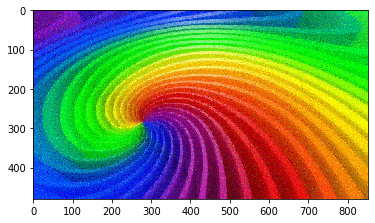

In [13]:
X_finish_new = np.zeros((image.shape[0], image.shape[1], 3))
X_finish_new[:,:,0] = X_red
X_finish_new[:,:,1] = X_blue
X_finish_new[:,:,2] = X_green
X_finish_new[X_finish_new < 0] = 0
plt.imshow(X_finish_new)